In [2]:
import numpy as np
import bisect

## Non stationary Environment

In [3]:
class Environment():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curve of average number of clicks (y = f(bids))
    self.average_cum_daily_cost = average_cum_daily_cost            # curve of cumulative daily cost (y = g(bids))
    self.noise_clicks = noise_clicks                                # gaussian noise for the average number of clicks sampling
    self.noise_cost = noise_cost                                    # gaussian noise for the cumulative daily cost sampling

  # daily rewards
  def bidding_round(self, pulled_bid):
    clicks = int(np.random.normal(self.average_number_of_clicks(self.bids[pulled_bid]),self.noise_clicks))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    costs = np.random.normal(self.average_cum_daily_cost(self.bids[pulled_bid]),self.noise_cost)                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0

    return reward_click, reward_cost

  def pricing_round(self, pulled_price):
    reward_price = np.random.binomial(1,self.probabilities[pulled_price])                         # number of people that buy once they clicked
    return reward_price

In [4]:
class NonStationnary(Environment):
  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost,
              time_abrupt_change_1, time_abrupt_change_2):
    super().__init__(n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost)
    self.time_abrupt_change_1 = time_abrupt_change_1
    self.time_abrupt_change_2 = time_abrupt_change_2
    
  def pricing_round(self, pulled_price):
    print("Error: Non-stationnary environment needs the time to know the conversion rates!")
    return float("NaN")
    
  def pricing_round(self, pulled_price, time):
    if time < self.time_abrupt_change_1:
      reward_price = np.random.binomial(1,self.probabilities[0,pulled_price])
    elif time < self.time_abrupt_change_2:
      reward_price = np.random.binomial(1,self.probabilities[1,pulled_price])
    else:
      reward_price = np.random.binomial(1,self.probabilities[2,pulled_price])
    return reward_price
    

## Pricing 

In [5]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [6]:
class TS_Pricing_Learner(Learner): # Thompson-Sampling (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                    # number of prices
    self.beta_parameters = np.ones((n_arms,2))  # parameters of beta distributions
    self.prices = prices                        # prices (array)

    #self.empirical_means = np.zeros(n_arms)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    sampled = np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1])*self.prices
    idx = np.argmax(sampled)
    #return idx, sampled[idx]
    return idx

  # update parameters each time a reward in {0,1} is observed
  def update(self,pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm,reward*self.prices[pulled_arm])
    self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
    self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1 - reward

    #self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])

In [7]:
class UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    #return pulled_arm, upper_bound[pulled_arm]
    #return pulled_arm, self.empirical_means[pulled_arm]
    return pulled_arm

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])
    for a in range(self.n_arms):
      self.confidence[a] = self.prices[a]*np.sqrt(2*np.log(self.t)/len(self.rewards_per_arm[a])) if len(self.rewards_per_arm[a]) > 0 else 1e3

In [8]:
class SW_UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices, tau=np.sqrt(1000*365)):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)
    self.tau = tau                                        # parameter for the confidence bound

  def count_elements_in_range(self, data, time, tau=0):
    start_time = time - tau if time - tau > 0 else 0
    start_index = bisect.bisect_left(data, (0, start_time)) 
    end_index = bisect.bisect_right(data, (0, time))
    count = end_index - start_index
    return count

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    
    for a in range(self.n_arms):
      if self.count_elements_in_range(self.rewards_per_arm[a], self.t - 1, self.tau) == 0:
        return a

    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    return pulled_arm

  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append((reward,self.t))
    self.collected_rewards = np.append(self.collected_rewards,reward)

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm][0]) - 1 - self.tau) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm][0])
    for a in range(self.n_arms):
      self.confidence[a] = self.prices[a]*np.sqrt(2*np.log(self.t)/self.count_elements_in_range(data=self.rewards_per_arm[a], time=(self.t - 1), tau=self.tau)) if self.count_elements_in_range(data=self.rewards_per_arm[a], time=(self.t - 1), tau=self.tau) > 0 else 1e3

## Simulation

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
# generic
T = 365                                # horizon of experiment
n_experiments = 100                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

In [11]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([[0.15,0.1,0.1,0.35,0.1],
              [0.5,0.2,0.1,0.1,0.1],
              [0.1,0.1,0.1,0.2,0.5]])             # bernoulli distributions for the reward functions

time_abrupt_change_1 = 100
time_abrupt_change_2 = 200
opt_rate_0 = p[0, np.argmax(p[0,:]*prices)]                 # optimal arm
opt_rate_1 = p[1, np.argmax(p[1,:]*prices)] 
opt_rate_2 = p[2, np.argmax(p[2,:]*prices)] 
print("Pricing (optimal price):")
print("Before change:")
print(" idx: " + str(np.argmax(p[0,:]*prices)) + 
      "  price: " + str(prices[np.argmax(p[0,:]*prices)]) + 
      "  rate: " + str(opt_rate_0) + 
      "  price*rate: " + str(opt_rate_0*prices[np.argmax(p[0,:]*prices)]))
print("After 1 change:")
print(" idx: " + str(np.argmax(p[1,:]*prices)) + 
      "  price: " + str(prices[np.argmax(p[1,:]*prices)]) + 
      "  rate: " + str(opt_rate_1) + 
      "  price*rate: " + str(opt_rate_1*prices[np.argmax(p[1,:]*prices)]))
print("After 2 changes:")
print(" idx: " + str(np.argmax(p[2,:]*prices)) + 
      "  price: " + str(prices[np.argmax(p[2,:]*prices)]) + 
      "  rate: " + str(opt_rate_2) + 
      "  price*rate: " + str(opt_rate_2*prices[np.argmax(p[2,:]*prices)]))

Pricing (optimal price):
Before change:
 idx: 3  price: 8  rate: 0.35  price*rate: 2.8
After 1 change:
 idx: 0  price: 5  rate: 0.5  price*rate: 2.5
After 2 changes:
 idx: 4  price: 9  rate: 0.5  price*rate: 4.5


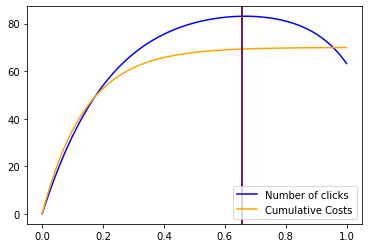

In [12]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = 3
sigma_costs = 3
def clicks(x):
  return 100 * (1.0 - np.exp(-4*x+3*x**3))
def costs(x):
  return 70 * (1.0 - np.exp(-7*x))
opt_bid_0 = bids[np.argmax(opt_rate_0*prices[np.argmax(p[0,:]*prices)]*clicks(bids)-costs(bids))]
opt_bid_1 = bids[np.argmax(opt_rate_1*prices[np.argmax(p[1,:]*prices)]*clicks(bids)-costs(bids))]
opt_bid_2 = bids[np.argmax(opt_rate_2*prices[np.argmax(p[2,:]*prices)]*clicks(bids)-costs(bids))]
fig, ax = plt.subplots()
ax.plot(bids,clicks(bids),'blue',bids,costs(bids),'orange')
ax.legend(["Number of clicks", "Cumulative Costs"])
ax.axvline(opt_bid_0,c='red')
ax.axvline(opt_bid_1,c='green')
ax.axvline(opt_bid_2,c='purple')
# print("Advertising (optimal bid):")
# print("idx: " + str(np.argmax(opt_rate*prices[np.argmax(p*prices)]*clicks(bids)-costs(bids))) + "  bid: " + str(opt_bid) + "  clicks-costs: " + str(clicks(opt_bid)-costs(opt_bid)))

## Known advertising

We are looking for the best $\tau$

In [48]:
n_experiments = 1  #CHECK FOR DIFFERENT VALUES OF n_experiments
taus = np.linspace(1,365,20) # FIND THE BEST TAU

# sw_ucb_rewards_per_experiment_per_tau = np.empty((len(taus), n_experiments))
sw_ucb_rewards_per_experiment_per_tau = np.array([])
print(sw_ucb_rewards_per_experiment_per_tau.shape)
print(sw_ucb_rewards_per_experiment_per_tau)


for tau in tqdm(taus):
    sw_ucb_rewards_per_experiment = np.array([])
    for e in range(n_experiments):
        env = NonStationnary(n_arms = n_prices,
                       probabilities = p,
                       bids = bids,
                       average_number_of_clicks = clicks,
                       average_cum_daily_cost = costs,
                       noise_clicks = sigma_clicks,
                       noise_cost = sigma_costs,
                       time_abrupt_change_1 = time_abrupt_change_1,
                       time_abrupt_change_2 = time_abrupt_change_2)
        learner = SW_UCB_Pricing_Learner(n_prices, prices, tau)

        sw_ucb_collected_costs = np.array([])
        sw_ucb_daily_pricing_reward = np.array([])
        
        for t in range(T):
            pulled_bid = np.argmax(clicks(bids)-costs(bids))
            reward_click, reward_cost = env.bidding_round(pulled_bid)
            sw_ucb_collected_costs = np.append(sw_ucb_collected_costs, reward_cost)

            for k in range(reward_click):
                pulled_price = learner.pull_arm()
                reward_price = env.pricing_round(pulled_price, t)
                learner.update(pulled_price, reward_price)
            sw_ucb_daily_pricing_reward = np.append(sw_ucb_daily_pricing_reward,(reward_click>0)*np.sum(learner.collected_rewards[-reward_click:]))

        print("Shape pricing:")
        print(sw_ucb_daily_pricing_reward.shape)
        print("Shape costs:")
        print(sw_ucb_collected_costs.shape)
        sw_ucb_rewards_per_experiment = np.append(sw_ucb_rewards_per_experiment, sw_ucb_daily_pricing_reward-sw_ucb_collected_costs)
        print("Shape rewards per experiment:")
        print(sw_ucb_rewards_per_experiment.shape)
    sw_ucb_rewards_per_experiment_per_tau = np.append(sw_ucb_rewards_per_experiment_per_tau,[sw_ucb_rewards_per_experiment])
    print("Shape rewards per experiment per tau:")
    print(sw_ucb_rewards_per_experiment_per_tau.shape)

(0,)
[]


  5%|████▏                                                                              | 1/20 [00:02<00:49,  2.58s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(365,)


C:\Users\alexa\AppData\Local\Temp/ipykernel_12572/4129765731.py:31: RuntimeWarning: overflow encountered in double_scalars
  self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm][0]) - 1 - self.tau) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm][0])
 10%|████████▎                                                                          | 2/20 [00:06<00:59,  3.30s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(730,)


 15%|████████████▍                                                                      | 3/20 [00:10<01:01,  3.63s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(1095,)


 20%|████████████████▌                                                                  | 4/20 [00:14<01:02,  3.94s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(1460,)


 25%|████████████████████▊                                                              | 5/20 [00:19<01:00,  4.03s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(1825,)


 30%|████████████████████████▉                                                          | 6/20 [00:23<00:58,  4.18s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(2190,)


 35%|█████████████████████████████                                                      | 7/20 [00:28<00:58,  4.52s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(2555,)


 40%|█████████████████████████████████▏                                                 | 8/20 [00:33<00:55,  4.62s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(2920,)


 45%|█████████████████████████████████████▎                                             | 9/20 [00:38<00:51,  4.67s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(3285,)


 50%|█████████████████████████████████████████                                         | 10/20 [00:42<00:46,  4.61s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(3650,)


 55%|█████████████████████████████████████████████                                     | 11/20 [00:47<00:41,  4.61s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(4015,)


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:52<00:37,  4.65s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(4380,)


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:57<00:34,  4.89s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(4745,)


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:02<00:29,  4.94s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(5110,)


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:07<00:24,  4.92s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(5475,)


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:12<00:19,  4.92s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(5840,)


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [01:18<00:15,  5.14s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(6205,)


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [01:23<00:10,  5.22s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(6570,)


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [01:29<00:05,  5.30s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(6935,)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:34<00:00,  4.72s/it]

Shape pricing:
(365,)
Shape costs:
(365,)
Shape rewards per experiment:
(365,)
Shape rewards per experiment per tau:
(7300,)


In [35]:
opt_0 = [opt_rate_0*prices[np.argmax(p[0,:]*prices)]*clicks(opt_bid_0) - costs(opt_bid_0) 
         for i in range(time_abrupt_change_1)]
opt_1 = [opt_rate_1*prices[np.argmax(p[1,:]*prices)]*clicks(opt_bid_1) - costs(opt_bid_1) 
         for i in range(time_abrupt_change_2-time_abrupt_change_1)]
opt_2 = [opt_rate_2*prices[np.argmax(p[2,:]*prices)]*clicks(opt_bid_2) - costs(opt_bid_2) 
         for i in range(T-time_abrupt_change_2)]
opt = np.array(opt_0 + opt_1 + opt_2)

In [40]:
sw_ucb_rewards_per_experiment_per_tau.shape

(7300,)

In [41]:
sw_rewards_per_tau = [[sw_ucb_rewards_per_experiment_per_tau[j] for j in range(365*i,365+i*365)]for i in range(0,20)]
len(sw_rewards_per_tau)

20

In [45]:
len(sw_rewards_per_tau[19])

365

In [43]:
len(opt)

365

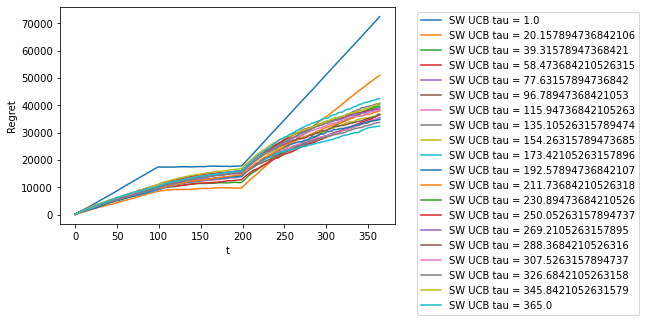

In [46]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
min = -1
min_ind = -1
for i in range(0, len(taus)):
    cumsum = np.cumsum(opt - sw_rewards_per_tau[i])
    if min > cumsum[-1] or min==-1:
        min = cumsum[-1]
        min_ind = i
    plt.plot(cumsum)
plt.legend(["SW UCB tau = " + str(taus[i]) for i in range(0, len(taus))], bbox_to_anchor=(1.05, 1), loc='upper left')

In [16]:
print("SW UCB tau = " + str(taus[min_ind]))

SW UCB tau = 1.0


In [17]:
# experiments
n_experiments = 100
ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []
sw_ucb_rewards_per_experiment = []

for e in tqdm(range(0,n_experiments)):  # cycle on experiments
  env = NonStationnary(n_arms = n_prices,
                       probabilities = p,
                       bids = bids,
                       average_number_of_clicks = clicks,
                       average_cum_daily_cost = costs,
                       noise_clicks = sigma_clicks,
                       noise_cost = sigma_costs,
                       time_abrupt_change_1 = time_abrupt_change_1,
                       time_abrupt_change_2 = time_abrupt_change_2)
  ts_learner = TS_Pricing_Learner(n_arms = n_prices,
                                       prices = prices)
  learner = UCB_Pricing_Learner(n_arms = n_prices,
                                    prices = prices)
  sw_learner = SW_UCB_Pricing_Learner(n_arms = n_prices, prices=prices, tau=int(np.sqrt(1000*365)))


  ts_collected_costs = np.array([])
  ucb_collected_costs = np.array([])
  ts_daily_pricing_reward = np.array([])
  ucb_daily_pricing_reward = np.array([])

  for t in range(0,T):  # cycle on time horizon

    # TS
    pulled_bid = np.argmax(clicks(bids)-costs(bids))
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    ts_collected_costs = np.append(ts_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price = ts_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price, t)
      ts_learner.update(pulled_price, reward_price)
    ts_daily_pricing_reward = np.append(ts_daily_pricing_reward,(reward_click>0)*np.sum(ts_learner.collected_rewards[-reward_click:]))


    # UCB
    pulled_bid = np.argmax(clicks(bids)-costs(bids))
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    ucb_collected_costs = np.append(ucb_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price = learner.pull_arm()
      reward_price = env.pricing_round(pulled_price, t)
      learner.update(pulled_price, reward_price)
    ucb_daily_pricing_reward = np.append(ucb_daily_pricing_reward,(reward_click>0)*np.sum(learner.collected_rewards[-reward_click:]))


  ts_rewards_per_experiment.append(ts_daily_pricing_reward - ts_collected_costs)
  ucb_rewards_per_experiment.append(ucb_daily_pricing_reward - ucb_collected_costs)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:20<00:00,  4.41s/it]


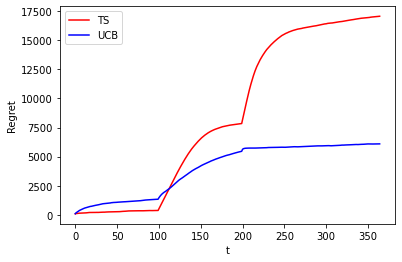

In [18]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis = 0)), 'b')
plt.legend(["TS", "UCB"])